# Fe test

In [1]:
import sys
sys.path.append('..')

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import logging
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.io import read
from asap3 import FullNeighborList

from m_ff.configurations import carve_confs

from m_ff.kernels import TwoBodySingleSpeciesKernel, ThreeBodySingleSpeciesKernel
from m_ff.gp import GaussianProcess, ThreeBodySingleSpeciesGP, TwoBodySingleSpeciesGP
from m_ff.grid import SingleSpeciesGrid

from m_ff.interpolation import Spline3D, Spline1D
from m_ff.calculators import TwoBodySingleSpecies, ThreeBodySingleSpecies, CombinedSingleSpecies

logging.basicConfig(level=logging.INFO)

## Parameters

In [4]:
# Parameters
directory = Path('data/Fe_vac/')

r_cut = 4.45
ntr = 10
ntest = 5


# GP Parameters
combine_2b_3b = True
sigma_2b = 0.3
sigma_3b = 0.6
noise = 0.0001

theta_2b = [sigma_2b, r_cut / 10.0, r_cut]
theta_3b = [sigma_3b, r_cut / 10.0, r_cut]


# mapping
grid_start = 1.5
elementslist = [26]
num_2b = 1000
num_3b = 100

## Configurations

In [5]:
# Parameters(
#     directory = Path('data/Fe_vac/'),
#     r_cut = 4.45,
#     sigma_2b = 0.3,
#     sigma_3b = 0.6,
#     noise = 0.0001,
#     theta_2b = [sigma_2b, r_cut / 10.0, r_cut]
#     theta_3b = [sigma_3b, r_cut / 10.0, r_cut]


#     # GP Parameters
#     ntr = 50,
#     ntest = 10,
#     combine_2b_3b = True,

#     # mapping
#     grid_start = 1.5,
#     elementslist = [26],
#     num_2b = 1000,
#     num_3b = 100
# )

In [6]:
# # # ----------------------------------------
# # # Construct a configuration database
# # # ----------------------------------------


# n_data = 50

# filename = directory / 'movie.xyz'

# traj = read(filename, index=slice(None), format='extxyz')

# elements, confs, forces, energies = carve_confs(
#     traj, r_cut, n_data,
#     forces_label='force', energy_label='energy')

# if not os.path.exists(directory):
#     os.makedirs(directory)

# np.save('{}/confs_cut={:.2f}.npy'.format(directory, r_cut), confs)
# np.save('{}/forces_cut={:.2f}.npy'.format(directory, r_cut), forces)
# np.save('{}/energies_cut={:.2f}.npy'.format(directory, r_cut), energies)

# lens = [len(conf) for conf in confs]

# logging.info('\n'.join((
#     'Number of atoms in a configuration:',
#     '   maximum: {}'.format(np.max(lens)),
#     '   minimum: {}'.format(np.min(lens)),
#     '   average: {:.4}'.format(np.mean(lens))
# )))

## GP

In [7]:
# ----------------------------------------
# Test a simple GP on the built database
# ----------------------------------------


# Get configurations and forces from file
confs = np.load(directory / 'confs_cut={:.2f}.npy'.format(r_cut))
forces = np.load(directory / 'forces_cut={:.2f}.npy'.format(r_cut))
numconfs = len(forces)
ind = np.arange(numconfs)
# ind_tot = np.random.choice(ind, size=ntr + ntest, replace=False)

# Separate into random testing and training dataset
# tr_confs, tr_forces = confs[ind[:ntr]], forces[ind[:ntr]]
# tst_confs, tst_forces = confs[ind[ntr:]], forces[ind[ntr:]]

# Use fixed training and testing dataset
tr_confs, tr_forces = confs[:ntr], forces[:ntr]
tst_confs, tst_forces = confs[-ntest - 1:-1], forces[-ntest - 1:-1]

In [8]:
two_body_train_forces = np.zeros((ntr, 3))

if combine_2b_3b:

    # First train with a 2 body
#     kernel_2b = TwoBodySingleSpeciesKernel(theta=theta_2b)
    gp_2 = TwoBodySingleSpeciesGP(theta=theta_2b, noise=noise)

    print('Training 2B GP')
    gp_2.fit(tr_confs, tr_forces)

    gp_2_name = 'gp_ker=2_ntr={}_sig={:.2f}_cut={:.2f}'.format(ntr, sigma_2b, r_cut)
    gp_2.save(directory / gp_2_name)

    # Calculate the predictions of the 2body on the training set
    for i in np.arange(ntr):
        two_body_train_forces[i] = gp_2.predict(np.reshape(tr_confs[i], (1, len(tr_confs[i]), 5)))

# Then train with a 2 body on the difference between tr_force and tr_force obtained with the two body
# kernel_3b = ThreeBodySingleSpeciesKernel(theta=theta_3b)
gp_3 = ThreeBodySingleSpeciesGP(theta=theta_3b, noise=noise, optimizer=None)

print('Training 3B GP')
gp_3.fit(tr_confs, tr_forces - two_body_train_forces)

gp_3_name = 'gp_ker=3_ntr={}_sig={:.2f}_cut={:.2f}'.format(ntr, sigma_3b, r_cut)
gp_3.save(directory / gp_3_name)

INFO:m_ff.kernels.twobody:Started compilation of theano two body single species kernels
INFO:m_ff.kernels.twobody:Ended compilation of theano two body single species kernels
INFO:m_ff.kernels.threebodykernel:Started compilation of theano three body kernels


Training 2B GP
Saved Gaussian process with name: data/Fe_vac/gp_ker=2_ntr=10_sig=0.30_cut=4.45


INFO:m_ff.kernels.threebodykernel:Ended compilation of theano three body kernels


Training 3B GP
Saved Gaussian process with name: data/Fe_vac/gp_ker=3_ntr=10_sig=0.60_cut=4.45


In [9]:
# Test the GP performance
print('Testing GP')

gp_3b_forces = np.zeros((ntest, 3))
gp_error = np.zeros((ntest, 3))
gp_2b_error = np.zeros((ntest, 3))
gp_2b_forces = np.zeros((ntest, 3))

for i in np.arange(ntest):
    if combine_2b_3b:
        gp_2b_forces[i, :] = gp_2.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
        gp_2b_error[i, :] = gp_2b_forces[i, :] - tst_forces[i, :]
    gp_3b_forces[i, :] = gp_3.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))
    gp_error[i, :] = gp_2b_forces[i, :] + gp_3b_forces[i, :] - tst_forces[i, :]

MAEF = np.mean(np.sqrt(np.sum(np.square(gp_error), axis=1)))
SMAEF = np.std(np.sqrt(np.sum(np.square(gp_error), axis=1)))
MAEF_2B = np.mean(np.sqrt(np.sum(np.square(gp_2b_error), axis=1)))
SMAE_2B = np.std(np.sqrt(np.sum(np.square(gp_2b_error), axis=1)))

MF = np.mean(np.linalg.norm(tst_forces, axis=1))

print('2 body MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF_2B, SMAE_2B))
print('MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF, SMAEF))
print('Relative MAEF on forces: {:.4f} +- {:.4f}'.format(MAEF / MF, SMAEF / MF))

# Testing GP
# 2 body MAEF on forces: 0.1539 +- 0.0901
# MAEF on forces: 0.3682 +- 0.1116
# Relative MAEF on forces: 0.4284 +- 0.1298

Testing GP
2 body MAEF on forces: 0.4896 +- 0.3612
MAEF on forces: 0.4492 +- 0.4135
Relative MAEF on forces: 0.6554 +- 0.6034


## Mapping

In [10]:
# ----------------------------------------
# Mapping
# ----------------------------------------

mapping_dists_2b = np.linspace(grid_start, r_cut, num_2b)
grid_2b = gp_2.build_grid(mapping_dists_2b, elementslist[0])


In [11]:
remap_2d_name = 'MFF_{}b_ntr_{}_sig_{:.2f}_cut_{:.2f}_num_{}.npy'.format(2, ntr, sigma_2b, r_cut, num_2b)
np.save(directory / remap_2d_name, [elementslist, mapping_dists_2b, grid_2b._data[1]])

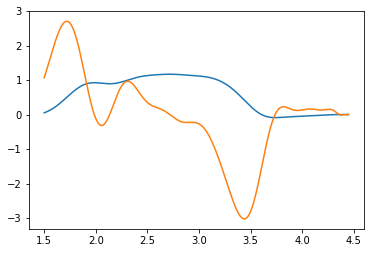

In [12]:
plt.plot(mapping_dists_2b, grid_2b(mapping_dists_2b, nu=0))
plt.plot(mapping_dists_2b, grid_2b(mapping_dists_2b, nu=1))

In [13]:
# ----------------------------------------
# Mapping 3b
# ----------------------------------------

mapping_dists_3b = np.linspace(grid_start, r_cut, num_3b)
grid_3b = gp_3.build_grid(mapping_dists_3b, elementslist[0])


In [14]:
remap_3d_name = 'MFF_{}b_ntr_{}_sig_{:.2f}_cut_{:.2f}_num_{}.npy'.format(3, ntr, sigma_3b, r_cut, num_3b)
np.save(directory / remap_3d_name, [elementslist, mapping_dists_3b, grid_3b.data])

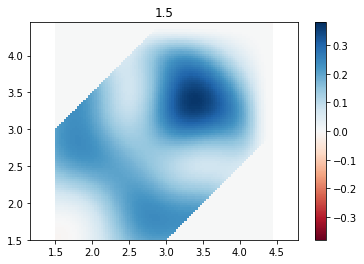

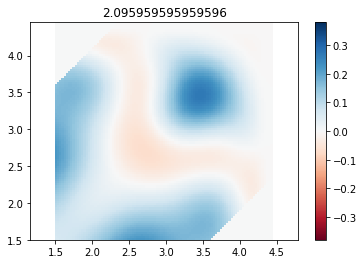

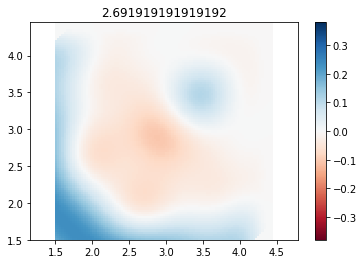

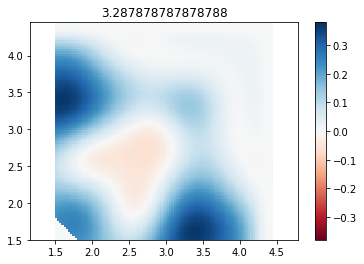

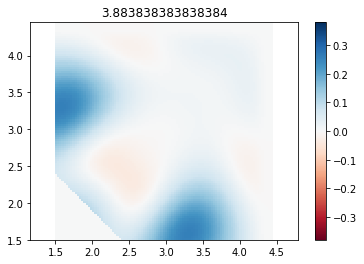

In [15]:
data = grid_3b.data
z_min, z_max = -np.max(np.abs(data)), np.max(np.abs(data))
for i in range(0, len(mapping_dists_3b), 20):
    plt.title(mapping_dists_3b[i])
    dists_k = np.ones_like(mapping_dists_3b) * mapping_dists_3b[i]
    plt.pcolor(mapping_dists_3b, mapping_dists_3b, -data[:,:,i], cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.colorbar()
    plt.axis('equal')

    plt.show()

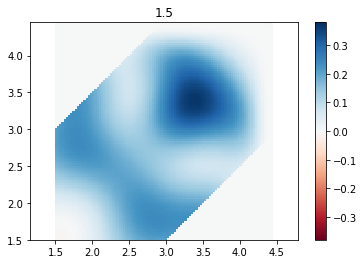

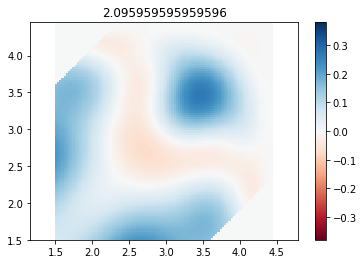

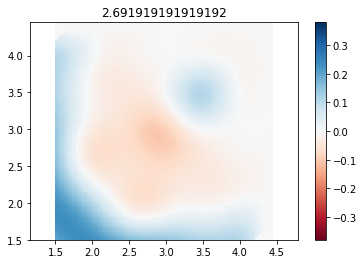

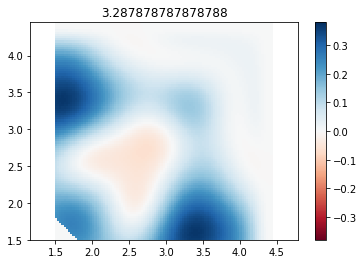

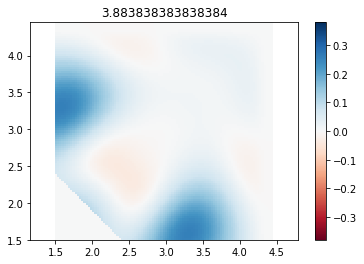

In [16]:
dist_range = mapping_dists_3b
dist_range = np.linspace(grid_start, r_cut, 100)

num = len(dist_range)

for i in range(0, len(mapping_dists_3b), 20):
    plt.title(dist_range[i])
    X, Y = np.meshgrid(dist_range, dist_range)
    g_data = grid_3b(X.flatten(), Y.flatten(), np.ones_like(X.flatten()) * mapping_dists_3b[i]).reshape(num, num)
    plt.pcolor(dist_range, dist_range, -g_data, cmap='RdBu', vmin=z_min, vmax=z_max)
    plt.colorbar()
    plt.axis('equal')

    plt.show()

## ASE Calculator

In [17]:

def rmse(x1, x2):
    rms = np.sqrt(np.sum(np.square(x1 - x2), axis=1))
    return np.mean(rms), np.std(rms)
    

In [18]:
# grid_2b = TwoBodySingleSpeciesGrid.from_file(str(directory / 'MFF_2b_ntr_20_sig_0.30_cut_4.45.npy'))
# grid_3b = ThreeBodySingleSpeciesGrid.from_file(str(directory / 'MFF_3b_ntr_20_sig_0.60_cut_4.45.npy'))

# calc = ThreeBodySingleSpecies(r_cut=4.45, grid_2b=grid_2b, grid_3b=grid_3b)


# filename = directory / 'movie.xyz'
# traj = read(str(filename), index=slice(0,5))
# for atoms in traj[0:5]:

#     atoms.set_calculator(calc)

#     rms_mean, rms_std = rmse(atoms.arrays['force'], atoms.get_forces())
#     print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))



In [19]:
calc = TwoBodySingleSpecies(r_cut, grid_2b)

filename = directory / 'movie.xyz'
traj = read(str(filename), index=slice(0, 5))

for atoms in traj:

    atoms.set_calculator(calc)

    rms_mean, rms_std = rmse(atoms.arrays['force'], atoms.get_forces())
    print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))
    
f2 = atoms.get_forces()

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


MAEF on forces: 0.2720 +- 0.1496
MAEF on forces: 0.2624 +- 0.1403
MAEF on forces: 0.2534 +- 0.1310
MAEF on forces: 0.2455 +- 0.1241
MAEF on forces: 0.2398 +- 0.1184


In [20]:
calc = ThreeBodySingleSpecies(r_cut, grid_3b)

filename = directory / 'movie.xyz'
traj = read(str(filename), index=slice(0, 5))

for atoms in traj:

    atoms.set_calculator(calc)

    rms_mean, rms_std = rmse(atoms.arrays['force'], atoms.get_forces())
    print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))

f3 = atoms.get_forces()

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


MAEF on forces: 0.9185 +- 0.3786
MAEF on forces: 0.9136 +- 0.3796
MAEF on forces: 0.9033 +- 0.3699
MAEF on forces: 0.8970 +- 0.3626
MAEF on forces: 0.8892 +- 0.3539


In [21]:
calc = CombinedSingleSpecies(r_cut, grid_2b, grid_3b)

filename = directory / 'movie.xyz'
traj = read(str(filename), index=slice(0, 5))

for atoms in traj:

    atoms.set_calculator(calc)

    rms_mean, rms_std = rmse(atoms.arrays['force'], atoms.get_forces())
    print('MAEF on forces: {:.4f} +- {:.4f}'.format(rms_mean, rms_std))

f23 = atoms.get_forces()

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


MAEF on forces: 0.3977 +- 0.1867
MAEF on forces: 0.3980 +- 0.1897
MAEF on forces: 0.3948 +- 0.1924
MAEF on forces: 0.3960 +- 0.1947
MAEF on forces: 0.3978 +- 0.1952


In [22]:
np.allclose(f2 + f3, f23)

True